# Gradient Boosting, XGBoost, and SHAP Values

## Goals: 
To be able to describe gradient boosting, and train XGBoost models on synthetic data. To learn about loss-guided tree growing, and then learn about SHAP (SHapley Additive exPlanations). The last goal is to see how SHAP value can provide individualized explanations for model predictions from any dataset, and to understand the additive property of SHAP values.

In [1]:
#Setup
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle

In [2]:
#Synthetic Set to use XGBoost on
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=40,\
n_informative=3, n_redundant=2,\
n_repeated=0, n_classes=2,\
n_clusters_per_class=3,\
weights=None, flip_y=0.05,\
class_sep=0.1, hypercube=True,\
shift=0.0,scale=1.0, shuffle=True,\
random_state=2)

In [3]:
y.mean()

0.4986

In [4]:
#Test/Train split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
train_test_split(X, y, test_size=0.2, random_state=24)

In [5]:
#XGBoost
xgb_model_1 = xgb.XGBClassifier(n_estimators=1000,\
verbosity=1,\
use_label_encoder=False,\
objective='binary:logistic',\
learning_rate=0.3)

`use_label_encoder` is deprecated in 1.7.0.


In [7]:
#Fit the model
xgb_model_1.fit(X_train, y_train,\
eval_metric="auc",\
verbose=True)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [8]:
#ROC AUC
val_set_pred_proba = xgb_model_1.predict_proba(X_val)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, val_set_pred_proba)

0.7787643196395633

In [9]:
#Early Boosting
eval_set = [(X_train, y_train), (X_val, y_val)]

In [13]:
#Fit with eval_set

xgb_model_1.fit(X_train, y_train, eval_set=eval_set,\
eval_metric='auc',\
verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.80412	validation_1-auc:0.75223
[1]	validation_0-auc:0.84422	validation_1-auc:0.79207
[2]	validation_0-auc:0.85920	validation_1-auc:0.79278
[3]	validation_0-auc:0.86616	validation_1-auc:0.79517
[4]	validation_0-auc:0.88261	validation_1-auc:0.79659
[5]	validation_0-auc:0.88605	validation_1-auc:0.80061
[6]	validation_0-auc:0.89226	validation_1-auc:0.80224


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[7]	validation_0-auc:0.89826	validation_1-auc:0.80305
[8]	validation_0-auc:0.90559	validation_1-auc:0.80095
[9]	validation_0-auc:0.91954	validation_1-auc:0.79685
[10]	validation_0-auc:0.92113	validation_1-auc:0.79608
[11]	validation_0-auc:0.92393	validation_1-auc:0.79763
[12]	validation_0-auc:0.92526	validation_1-auc:0.79842
[13]	validation_0-auc:0.92699	validation_1-auc:0.79883
[14]	validation_0-auc:0.93105	validation_1-auc:0.79716
[15]	validation_0-auc:0.94393	validation_1-auc:0.79750
[16]	validation_0-auc:0.95007	validation_1-auc:0.79431
[17]	validation_0-auc:0.95204	validation_1-auc:0.79407
[18]	validation_0-auc:0.95610	validation_1-auc:0.79127
[19]	validation_0-auc:0.95920	validation_1-auc:0.79136
[20]	validation_0-auc:0.96175	validation_1-auc:0.79044
[21]	validation_0-auc:0.96329	validation_1-auc:0.78943
[22]	validation_0-auc:0.96978	validation_1-auc:0.78885
[23]	validation_0-auc:0.97344	validation_1-auc:0.78685
[24]	validation_0-auc:0.97510	validation_1-auc:0.78467
[25]	validati

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [14]:
xgb_model_1.get_booster().attributes()

{'best_iteration': '7',
 'best_ntree_limit': '8',
 'best_score': '0.8030501882609966'}

In [15]:
#ROC AUC Score
val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
roc_auc_score(y_val, val_set_pred_proba_2)

0.8030501882609966

In [16]:
#Tuning the Learning Rate
learning_rates = np.linspace(start=0.01, stop=1, num=25)

In [21]:
val_aucs = []
best_iters = []
for learning_rate in learning_rates:
    xgb_model_1.set_params(**{'learning_rate':learning_rate})
    xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric='auc',
                    verbose=False, early_stopping_rounds=30)
    
    #Get Validation Score
    val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba_2))
    
    #Number of rounds for each learning rate
    best_iters.append(int(xgb_model_1.get_booster().attributes()['best_iteration']))

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

In [22]:
#Put results into dataframe
learning_rate_df = pd.DataFrame({'Learning rate':learning_rates,'Validation AUC':val_aucs,'Best iteration':best_iters})

<AxesSubplot:xlabel='Learning rate'>

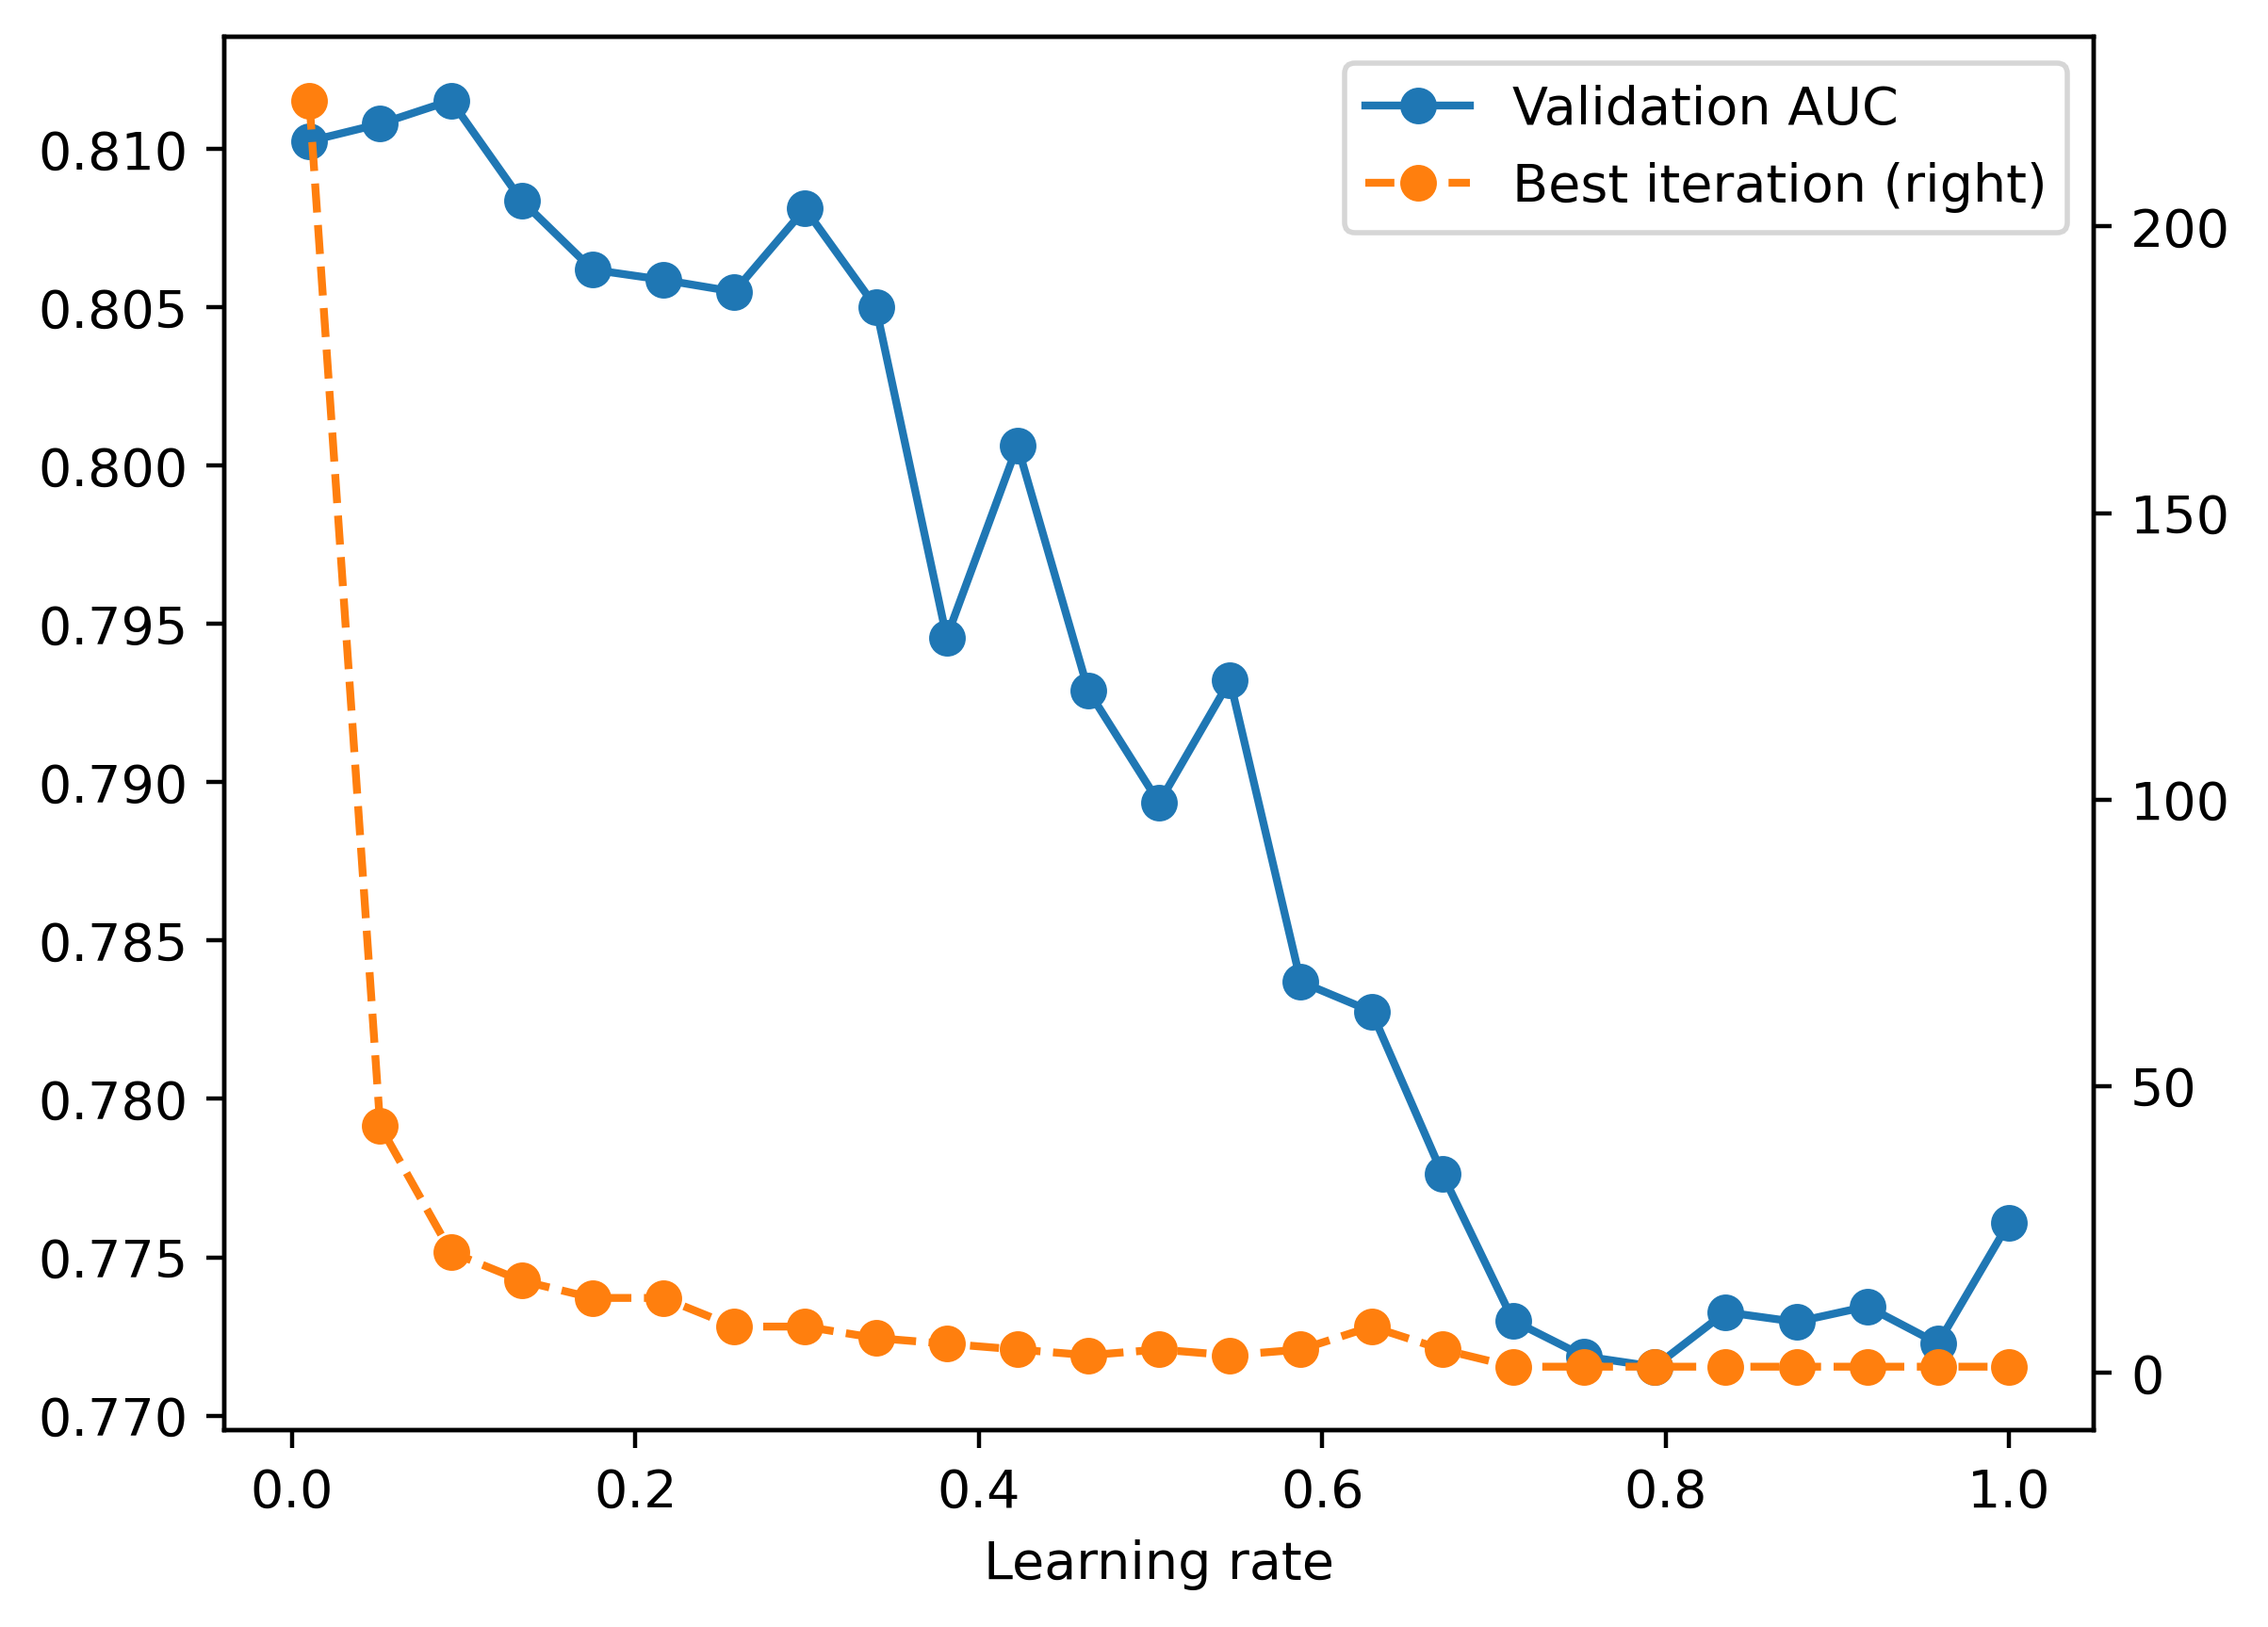

In [23]:
#Plot
mpl.rcParams['figure.dpi'] = 400
learning_rate_df.set_index('Learning rate').plot(secondary_y='Best iteration', style=['-o', '--o'])

In [24]:
max(val_aucs)

0.8115309360232714

In [25]:
#Randomized Grid Search for Tuning XGBoost Hyperparameters
from scipy.stats import uniform
param_grid = {'max_depth':[2,3,4,5,6,7],
'gamma':uniform(loc=0.0, scale=3),
'min_child_weight':list(range(1,151)),
'colsample_bytree':uniform(loc=0.1, scale=0.9),
'subsample':uniform(loc=0.5, scale=0.5),
'learning_rate':uniform(loc=0.01, scale=0.5)}

In [26]:
#Sampling
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(0)
n_iter=1000
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
random_state=rng))

In [27]:
param_list[0]

{'colsample_bytree': 0.5939321535345923,
 'gamma': 2.1455680991172583,
 'learning_rate': 0.31138168803582195,
 'max_depth': 5,
 'min_child_weight': 104,
 'subsample': 0.7118273996694524}

In [28]:
## ** lets you set multiple XGBoost Hyperparameters simultaneously
xgb_model_2 = xgb.XGBClassifier(
n_estimators=1000,
verbosity=1,
use_label_encoder=False,
objective='binary:logistic')
xgb_model_2.set_params(**param_list[0])

`use_label_encoder` is deprecated in 1.7.0.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5939321535345923, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.1455680991172583, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.31138168803582195, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=104, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
val_aucs = []
counter = 1

for params in param_list:
    #Set hyperparameters and fit model
    xgb_model_2.set_params(**params)
    xgb_model_2.fit(X_train, y_train, eval_set=eval_set,eval_metric='auc',\
    verbose=False, early_stopping_rounds=30)
    
    #Get predicted probabilities and save validation ROC AUC
    val_set_pred_proba = xgb_model_2.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))
    
    #Print progress
    if counter % 50 == 0:
        print('Done with {counter} of {n_iter}'.format(counter=counter, n_iter=n_iter))
    counter += 1

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 50 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 100 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 150 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 200 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 250 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 300 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 350 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 400 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 450 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 500 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 550 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 600 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 650 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 700 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 750 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 800 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 850 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 900 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 950 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

Done with 1000 of 1000


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [30]:
#Results from Hyperparameter Exploration
xgb_param_search_df = pd.DataFrame(param_list)
xgb_param_search_df.head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample
0,0.593932,2.145568,0.311382,5,104,0.711827
1,0.681305,1.312762,0.455887,2,141,0.691721
2,0.812553,1.586685,0.294022,7,26,0.535518
3,0.178416,0.060655,0.426310,2,83,0.736804
4,0.820820,1.561432,0.349440,2,10,0.768687


In [31]:
#Add ROC AUC to Dataframe
xgb_param_search_df['Validation ROC AUC'] = val_aucs
max_auc = xgb_param_search_df['Validation ROC AUC'].max()
max_auc

0.8162024495936684

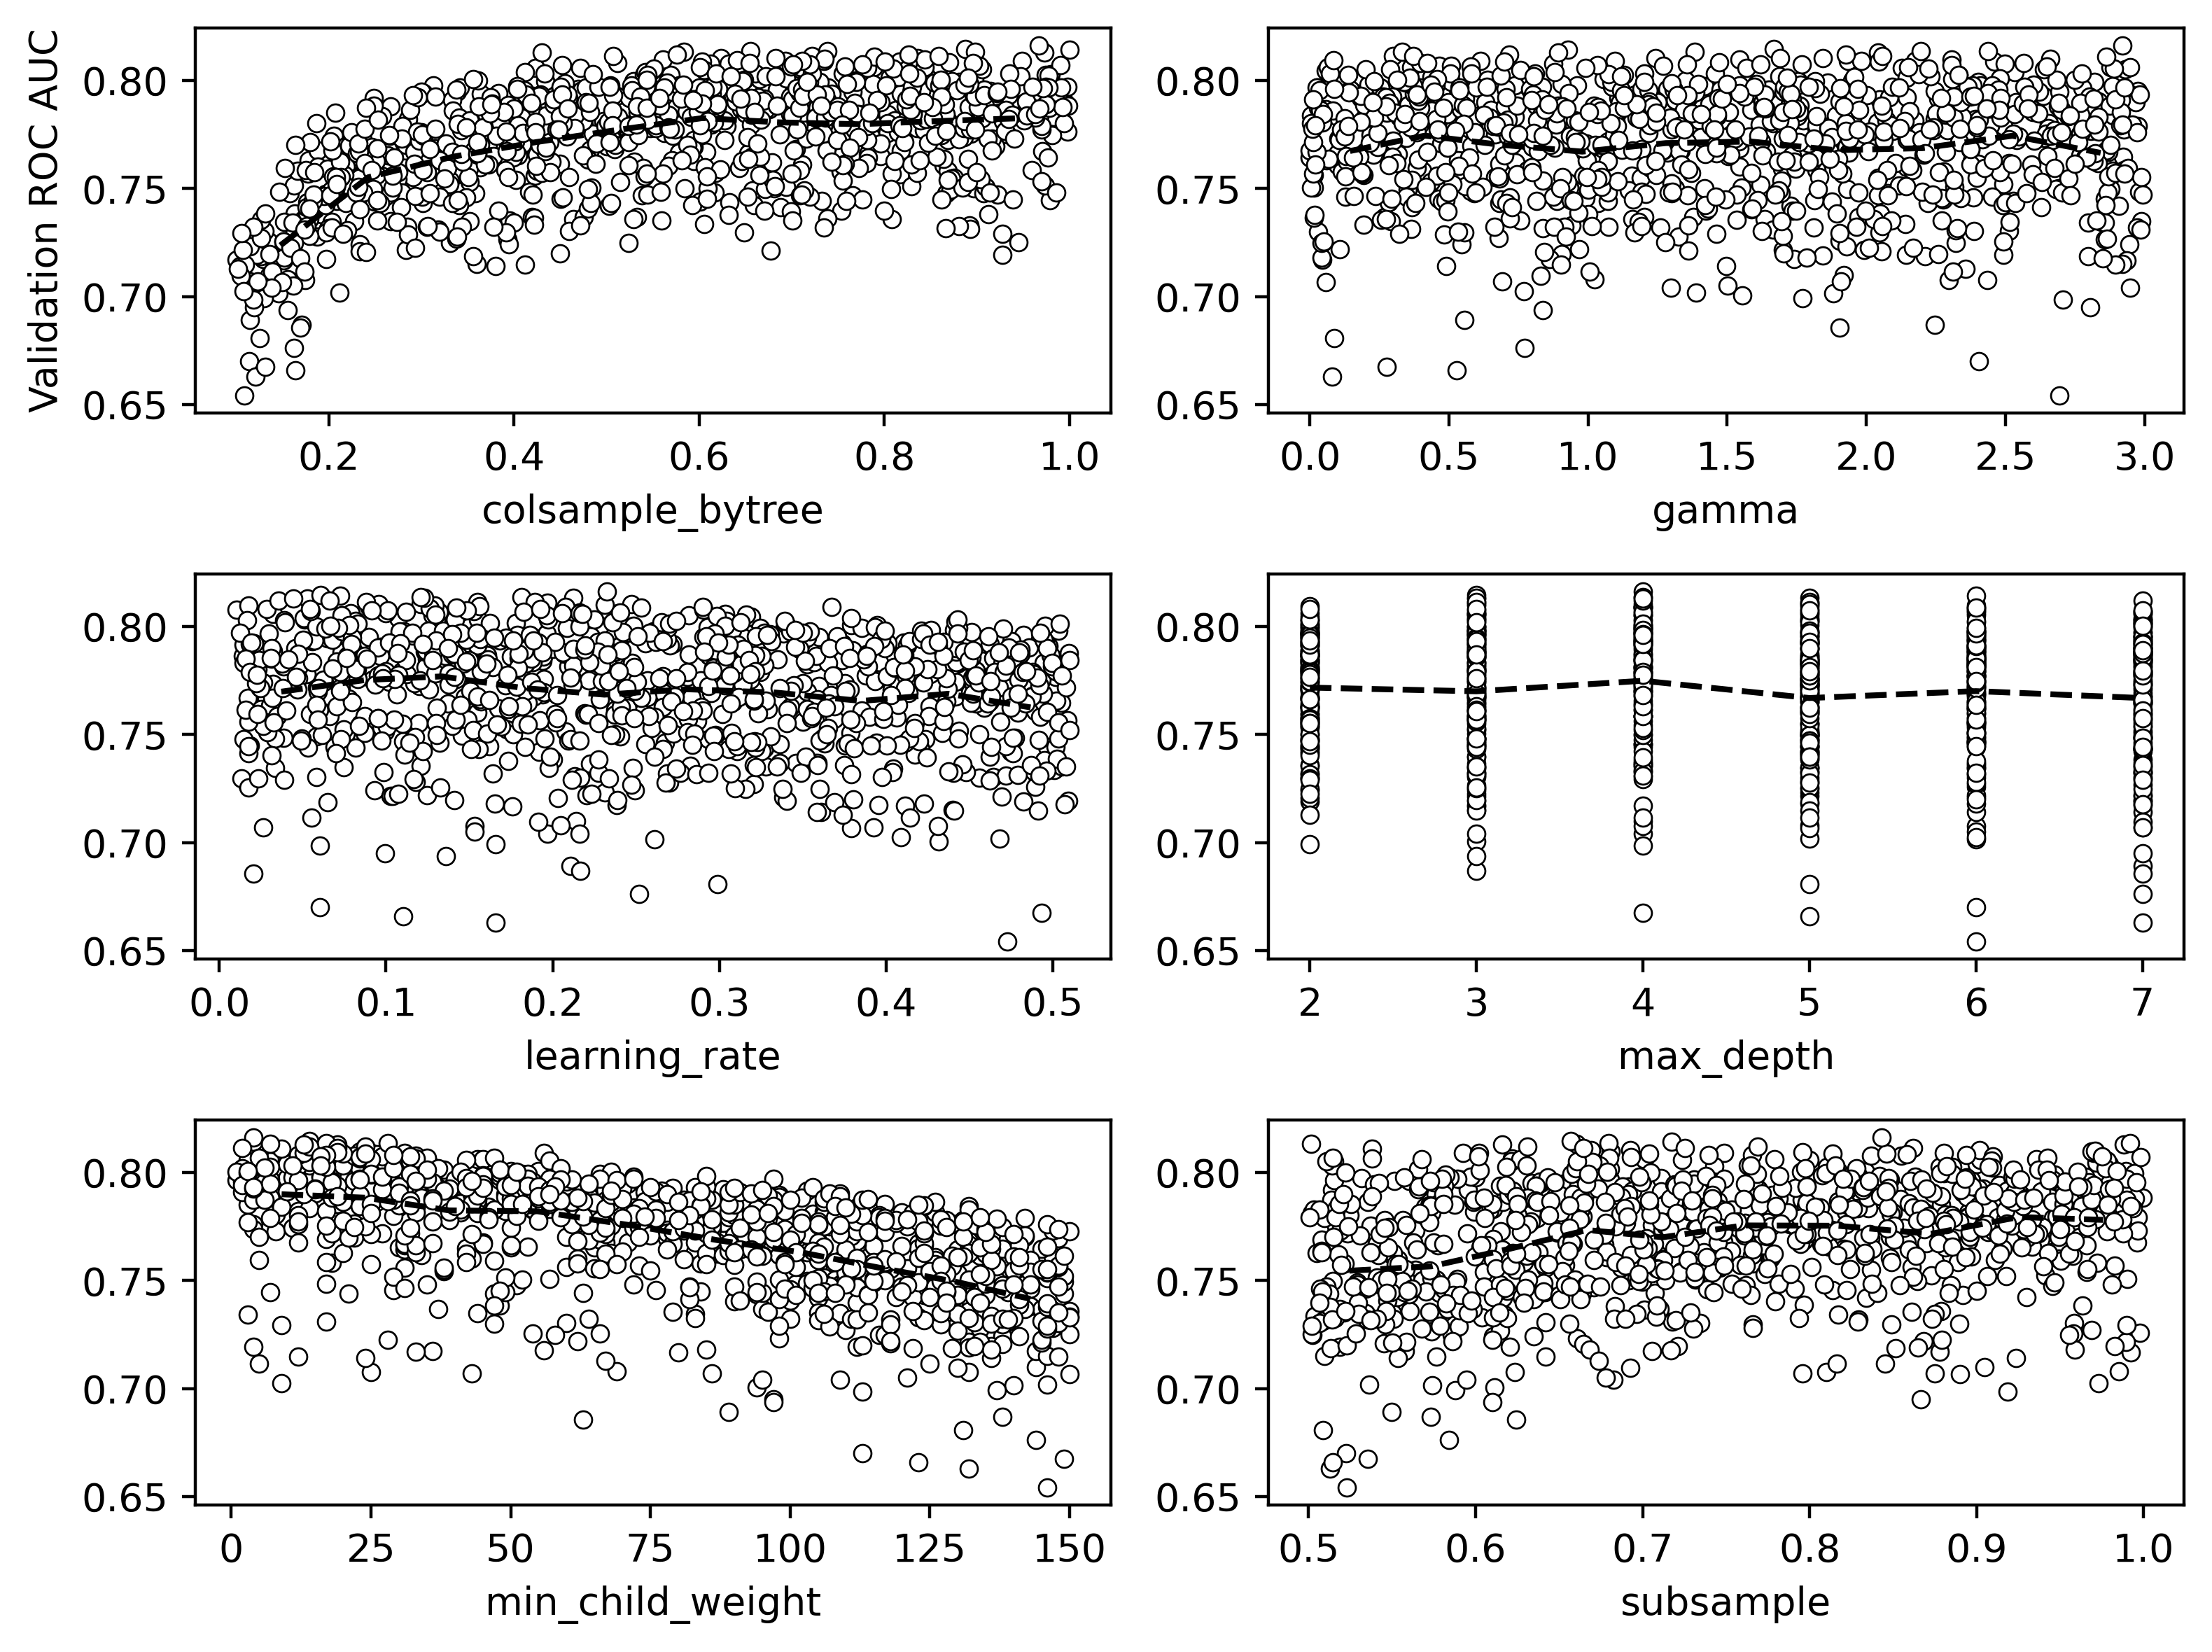

In [35]:
#Plot performance against each hyperparameter
mpl.rcParams['figure.dpi'] = 400
fig, axs = plt.subplots(3,2,figsize=(8,6))
counter = 0
for col in xgb_param_search_df.columns[:-1]:
#     print(col)
    this_ax = axs.flatten()[counter]
    xgb_param_search_df.plot.scatter(
        x=col, y='Validation ROC AUC',
        ax=this_ax, marker='o',
        color='w',
        edgecolor='k',
        linewidth=0.5)
    
    if counter > 0:
        this_ax.set_ylabel('')
    counter += 1
    
    if col != 'max_depth':
        out, bins = pd.qcut(xgb_param_search_df[col], q=10,
                            retbins=True, duplicates='drop')
        half_points = [(bins[ix] + bins[ix+1])/2
                       for ix in range(len(bins)-1)]
    else:
        out = xgb_param_search_df[col]
        half_points = np.sort(xgb_param_search_df[col].unique())
        
    tmp_df = xgb_param_search_df.copy()
    tmp_df['param_decile'] = out
    mean_df = tmp_df.groupby('param_decile').agg(
        {'Validation ROC AUC':'mean'})
    
    this_ax.plot(half_points, mean_df.values, color='k', linestyle='--')
plt.tight_layout()


In [36]:
#Which Hyperparameter combination is best?
max_ix = xgb_param_search_df['Validation ROC AUC'] == max_auc
xgb_param_search_df[max_ix]

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,Validation ROC AUC
656,0.966784,2.921293,0.232501,4,4,0.843022,0.816202


## ``Logloss`` Tree Growing

In [37]:
#XGBoost Model for Logloss
xgb_model_3 = xgb.XGBClassifier(
n_estimators=1000,
max_depth=0,
learning_rate=0.1,
verbosity=1,
objective='binary:logistic',
use_label_encoder=False,
n_jobs=-1,
tree_method='hist',
grow_policy='lossguide')

`use_label_encoder` is deprecated in 1.7.0.


`max_depth` is 0 since it is not relevant for the `lossguide` policy. `max_leaves` is the parameter we will use.

In [38]:
max_leaves_values = list(range(5,105,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[80, 85, 90, 95, 100]


In [39]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model_3.set_params(**{'max_leaves':max_leaves})
    xgb_model_3.fit(X_train, y_train, eval_set=eval_set,eval_metric='auc', verbose=False,early_stopping_rounds=30)

    #Get validation score
    val_set_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

CPU times: user 1min 40s, sys: 1.54 s, total: 1min 42s
Wall time: 13.8 s


In [40]:
#Put max_leaves result in a dataframe
max_leaves_df = pd.DataFrame({'Max leaves':max_leaves_values,'Validation AUC':val_aucs})

<AxesSubplot:xlabel='Max leaves'>

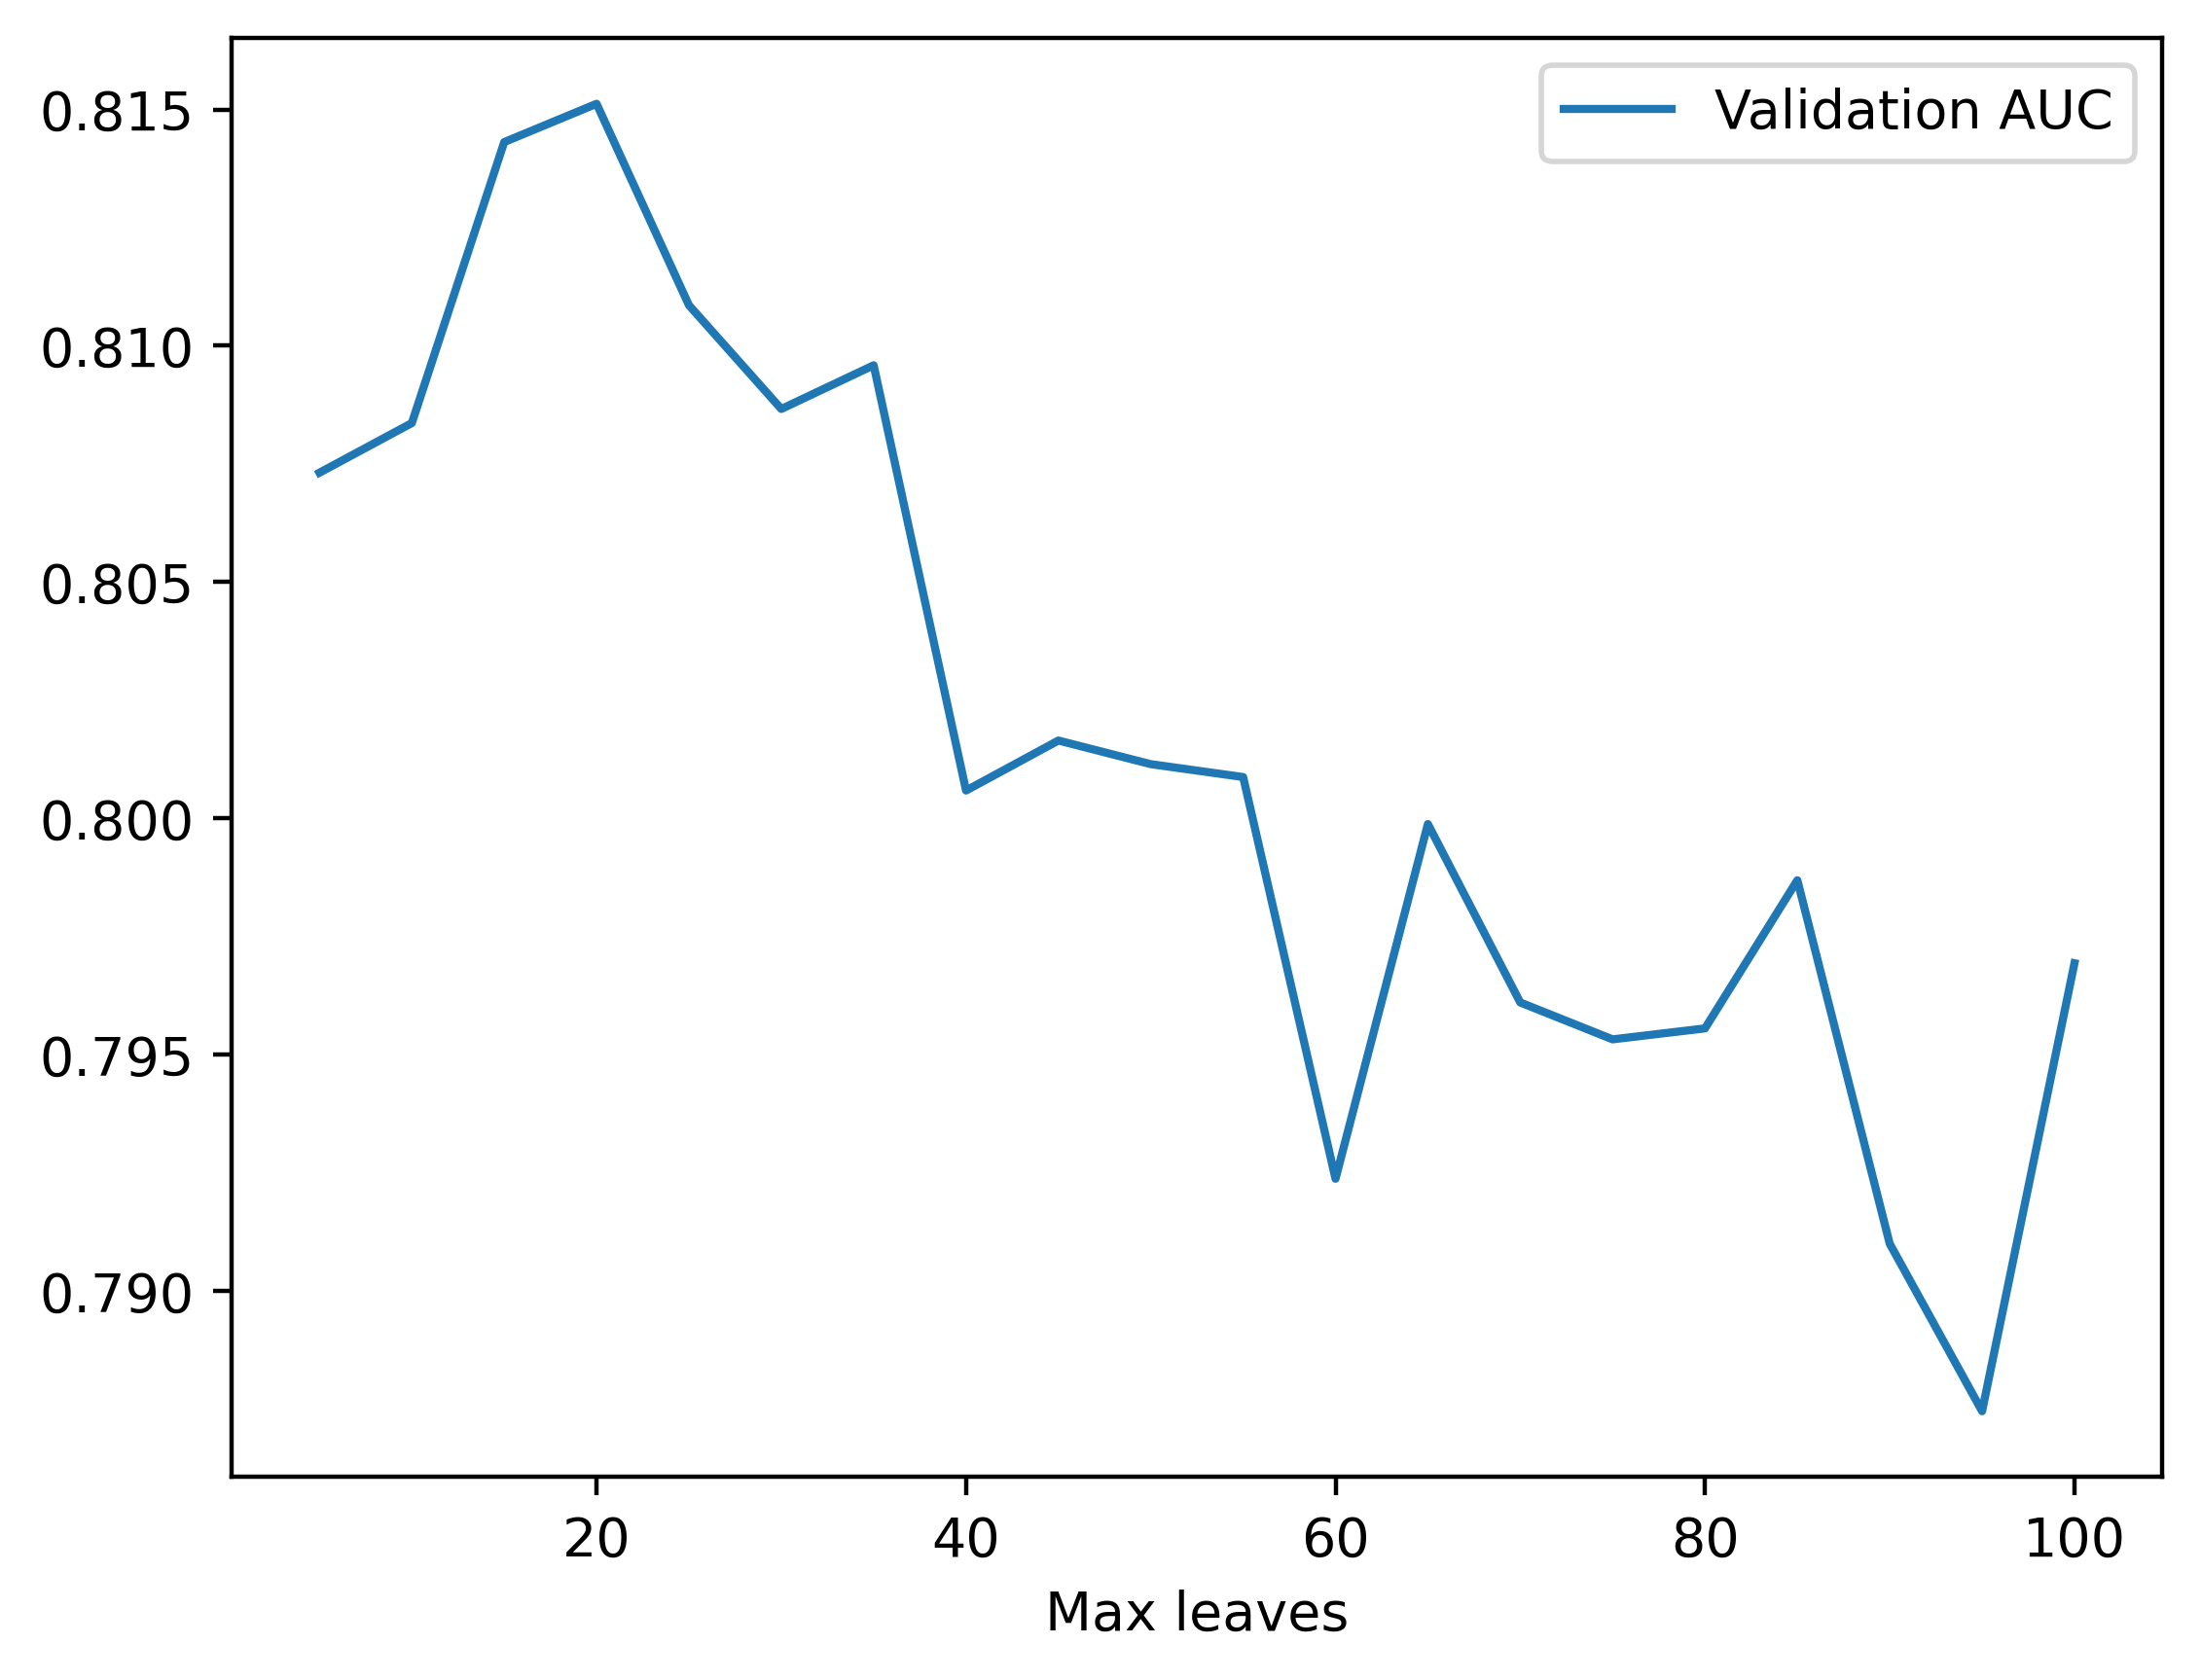

In [41]:
#Plot how validation AUC changes with max number of leaves
mpl.rcParams['figure.dpi'] = 400
max_leaves_df.set_index('Max leaves').plot()

In [42]:
#Max AUC
max_auc = max_leaves_df['Validation AUC'].max()
max_auc

0.8151200989120475

In [43]:
#Index of Max AUC
max_ix = max_leaves_df['Validation AUC'] == max_auc
max_leaves_df[max_ix]

,Max leaves,Validation AUC
3,20,0.81512


## Explaining Model Predictions with SHAP Values

In [45]:
%%time

#Refit XGBoost Model with max_leaves = 20
xgb_model_3.set_params(**{'max_leaves':20})
xgb_model_3.fit(X_train, y_train,\
eval_set=eval_set,\
eval_metric='auc',
verbose=False,\
early_stopping_rounds=30)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


CPU times: user 3.07 s, sys: 91.5 ms, total: 3.16 s
Wall time: 443 ms


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=0, max_leaves=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [46]:
X_val.shape

(1000, 40)

In [47]:
#Prepare to label with the SHAP package
feature_names = ['Feature {number}'.format(number=number)
for number in range(X_val.shape[1])]
X_val_df = pd.DataFrame(data=X_val, columns=feature_names)
X_val_df.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39
0,1.852885,-2.170293,1.057288,0.441873,-0.803131,-0.025139,-0.037143,0.037565,1.163995,0.678410,...,-0.592176,0.529113,0.923351,0.511203,-0.390155,-0.142262,0.760561,-0.421488,1.770300,-0.292780
1,-0.818316,-1.126948,0.647810,0.092433,-1.030356,0.754323,-0.351566,-0.523476,1.144878,0.219172,...,0.545090,1.125089,0.848158,-0.870549,-1.094581,-1.480010,-2.444469,0.905715,-1.008522,1.537315
2,0.020271,-0.758004,-1.136195,0.473366,1.291465,0.890423,-2.217706,-2.030749,1.768624,-2.106202,...,-0.741205,-0.833958,-0.265291,-1.021137,0.247897,-0.058583,0.445473,0.349382,0.208958,0.252826
3,-0.271543,-0.366639,-1.139614,-0.753586,1.427853,1.249856,0.060528,-0.374193,0.047770,0.640638,...,-0.539878,0.569599,0.508334,-0.513756,0.769438,1.100097,0.682759,0.888623,-0.464301,-1.125279
4,-0.549078,0.494648,-1.266778,-0.292728,1.459779,0.497898,-0.618724,-1.225373,0.171507,0.833027,...,-0.366978,-0.308615,0.838910,0.208853,2.517458,0.471553,0.982017,0.030594,0.449982,-0.670582


In [49]:
#Explainer for SHAP
explainer = shap.explainers.Tree(xgb_model_3, data=X_val_df)

In [50]:
shap_values = explainer(X_val_df)
shap_values.values.shape

(1000, 40)

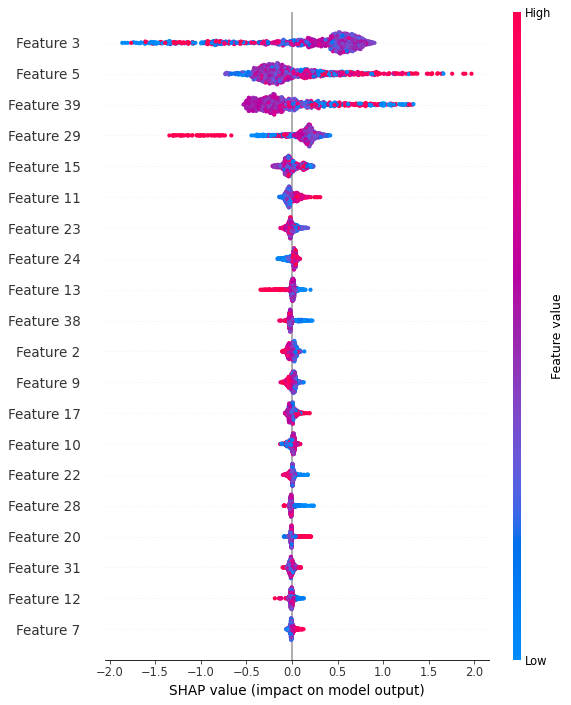

In [51]:
#Plot SHAP Values
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_val_df)

Feature 3 is the strongest feature. Let's give it a scatter plot to find more insights.

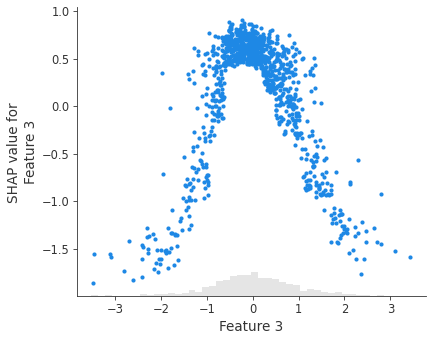

In [52]:
shap.plots.scatter(shap_values[:,'Feature 3'])

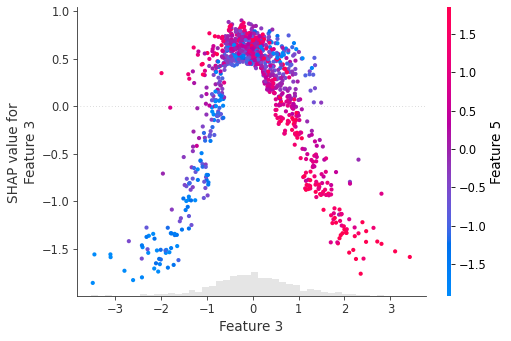

In [53]:
#Plot the two most important features - 3 and 5
shap.plots.scatter(shap_values[:,'Feature 3'],color=shap_values[:,'Feature 5'])

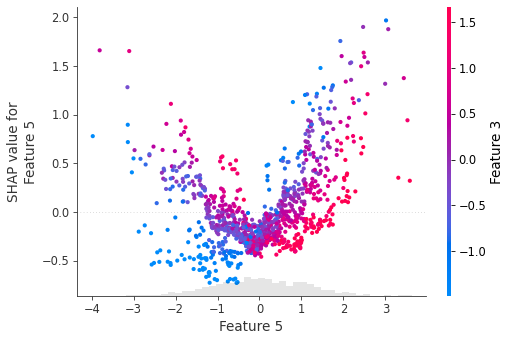

In [54]:
#Plot Features 5 and 3
shap.plots.scatter(shap_values[:,'Feature 5'],
color=shap_values[:,'Feature 3'])

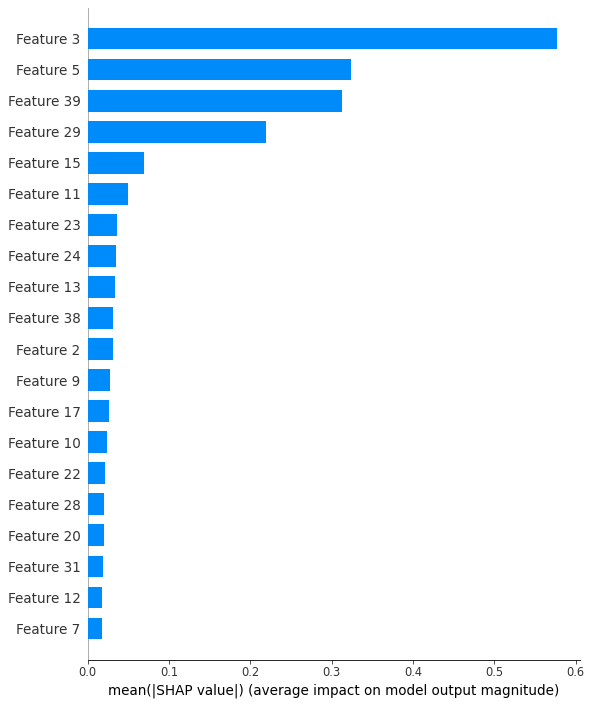

In [55]:
#Importance Bar
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_val, plot_type='bar')

In [56]:
#Expected Value
explainer.expected_value

-0.3094962194637628

In [57]:
#Sum of SHAP values for each samp;e
shap_sum = shap_values.values.sum(axis=1) + explainer.expected_value
shap_sum.shape

(1000,)

In [58]:
shap_sum_prob = 1 / (1 + np.exp(-1 * shap_sum))

In [59]:
#Predicted Probabilities
y_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
y_pred_proba.shape

(1000,)

In [60]:
#Compare SHAP Sum and Predicted Probabilities
df_check = pd.DataFrame({'SHAP sum':shap_sum_prob,'Predicted probability':y_pred_proba})
df_check.sample(5, random_state=1)

,SHAP sum,Predicted probability
507,0.497260,0.497260
818,0.466160,0.466160
452,0.881343,0.881343
368,0.145347,0.145347
242,0.481065,0.481065
